`63070501061 S.RAKNA`

# Handwritten Digit Recognition

- Use the `digit.png` file as template for digits `0, 1, ..., 9`. 
- Write a *python* program to cut out each digit as a label dataset from `0...9`, each of which is `20*20` pixel.
> Note: You may also use this *exact same sataset* with 100 samples of each digit 0..9 using 20*20 pixels from the internet along with libraries to read/load the dataset, if it's easier for you.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from cv2 import Mat


class Grid:
    def __init__(self, digit: Mat, label: str):
        self.digit = digit
        self.label = label
        self.gray_scale_feature = None
        self.hog_feature = None

    def plot(self) -> None:
        """Plot the digit"""
        plt.imshow(self.digit, cmap='gray')
        plt.title("Label: {}".format(self.label))
        plt.show()

    def set_gray_scale_feature(self, gray_scale_feature: np.ndarray) -> None:
        """Set the gray scale feature"""
        self.gray_scale_feature = gray_scale_feature

    def set_hog_feature(self, hog_feature: np.ndarray) -> None:
        """Set the HOG feature"""
        self.hog_feature = hog_feature

    def set_digit(self, digit: Mat) -> None:
        """Set the digit"""
        self.digit = digit

    def get_digit(self) -> Mat:
        """Get the digit"""
        return self.digit


In [3]:
DIMENSION = 20


class Template:
    def __init__(self, path):
        self.path = path
        self.image = None
        self.h = 0
        self.w = 0
        self.rows = 0
        self.cols = 0
        self.grids: Mat = []

    def plot_template(self) -> None:
        """Plot the template"""
        if self.image is None:
            self.read_file()
        plt.figure(figsize=(20, 20))
        plt.imshow(self.image, cmap='gray')
        plt.title("Template")
        plt.show()

    def read_file(self) -> None:
        """Read the file"""
        self.image = cv2.imread(self.path)
        self.h, self.w = self.image.shape[:2]
        print("height: {}, width: {}".format(self.h, self.w))

    def cut(self, actual_dimension: int = DIMENSION, excepted_dimension: int = DIMENSION) -> None:
        """Cut the image into a list of images of the same size OR resize the image to the excepted size"""

        if self.image is None:
            self.read_file()
        # Get the number of rows and columns
        observed_repeat_row = 5  # 5 is observed from the template
        self.rows = self.h // (actual_dimension * observed_repeat_row)
        self.cols = (self.w // actual_dimension) * observed_repeat_row

        x, y = 0, 0

        for i in range(self.rows):
            for j in range(self.cols):
                # x, start with top-left corner and move to the right by actual_dimension
                # y, start with top-left corner and move to the bottom by actual_dimension
                digit = self.image[y:y + actual_dimension,
                                   x:x + actual_dimension]
                # self.plot_digit(digit, "digit: {}, {}".format(i, j))
                # If the image is not the except_size, resize it
                if excepted_dimension != actual_dimension:
                    try:
                        digit = cv2.resize(
                            digit, (excepted_dimension, excepted_dimension))
                    except cv2.error:
                        print("error at digit: {}, {}".format(i, j))

                x += actual_dimension
                # when x is out of bound, reset x to 0 and move y to the next row
                if x >= self.w:
                    x = 0
                    y += actual_dimension

                # Create a Grid object and append it in the array
                self.grids.append(Grid(digit, str(i)))


In [4]:
# Read the template's source file and then init the Template object
template = Template('digits.png')
template.plot_template()

height: 1000, width: 2000


- Rescale all images from `20 x 20` **to** `24 x 24`. 
> This can be done in memory as a python class data and need not be stored in a file. 

In [5]:
# cutting the digits from the template
EXPECTED_DIMENSION = 24
template.cut(excepted_dimension=EXPECTED_DIMENSION) # Already resize the image to 24x24 as expected


- Use `80%` of the data as the training set, reserving `20%` for testing.

In [6]:
# split 80% for training and 20% for testing
from sklearn.model_selection import train_test_split
TRAIN_SIZE = 0.8

# split the data into training and testing
train, test = train_test_split(
    template.grids, train_size=TRAIN_SIZE, random_state=0)


> From now, we resizes the images to `24 x 24` pixels. and also split the dataset.
> 
> Here is some example of test data.

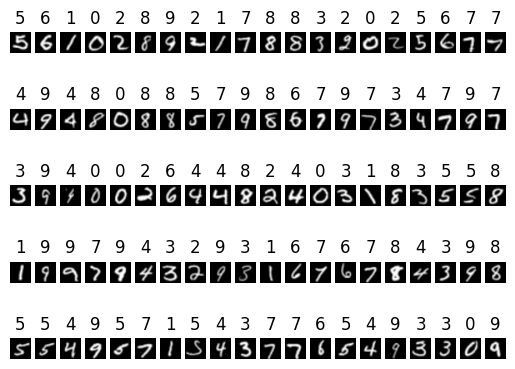

In [7]:
plt.figure()
for i in range(100):
    plt.subplot(5, 20, i + 1)
    plt.imshow(train[i].digit, cmap='gray')
    plt.title(train[i].label)
    plt.axis('off')
plt.show()


> 30 pts.
> 6 hrs.

### `a.` Then try recognition by using test images and report the accuracy percent for these 4 (classifier, feature type) combinations: 
|K|features|
|---|----------|
|5|gray scale|
|5|HOG|
|1|gray scale|
|1|HOG|
- For `K = 5`, if 2 or more digits have the same maximum vote count, just report one of them. 
- For `HOG`, use **20° histogram orientations of non-directional gradients** (ie., 9 bins) with **16 x 16 overlapping pixel windows for each 24 x 24 digit**. Each digit will, thus, have 144 HOG features from 4 x 4 x 9, with 9 histo values x 4 per 16 x 16 block x 4 such blocks per 24 x 24 image.

> Set gray scale feature

In [8]:
for grid in train:
    gray_scale_feature = cv2.cvtColor(grid.digit, cv2.COLOR_BGR2GRAY)
    grid.set_gray_scale_feature(gray_scale_feature)

for grid in test:
    gray_scale_feature = cv2.cvtColor(grid.digit, cv2.COLOR_BGR2GRAY)
    grid.set_gray_scale_feature(gray_scale_feature)

# print the HOG feature of the first digit
# print("Gray scale feature of some digit: \n", train[0].gray_scale_feature)
print("Number of Features: ", train[0].gray_scale_feature.shape)


Number of Features:  (24, 24)


> Set HOG feature

In [9]:
# define the HOG descriptor
winSize = (EXPECTED_DIMENSION, EXPECTED_DIMENSION)
blockSzie = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = False
# nlevels = 64
# signedGradient = False

hog = cv2.HOGDescriptor(
    winSize,
    blockSzie,
    blockStride,
    cellSize,
    nbins,
    derivAperture,
    winSigma,
    histogramNormType,
    L2HysThreshold,
    gammaCorrection
)

winStride = (8, 8)
padding = (8, 8)
locations = ((0, 0),)  # run at position (0,0) of the image

# apply hog.compute to each digit
for grid in train:
    hog_feature = hog.compute(grid.digit, winStride, padding, locations)
    grid.set_hog_feature(hog_feature)

for grid in test:
    hog_feature = hog.compute(grid.digit, winStride, padding, locations)
    grid.set_hog_feature(hog_feature)

# print the HOG feature of the first digit
# print("HOG feature of some digit: \n", train[0].hog_feature)
print("Number of Features: ", train[0].hog_feature.shape)
# print("This is from 9 histo values x 4 per 16x16 block x 4 such blocks per 24x24 image: ", 9*4*4)


Number of Features:  (144,)


> KNN classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Training
# K = 5, Gray scale feature
knn_gray_scale_5 = KNeighborsClassifier(n_neighbors=5)
knn_gray_scale_5.fit([grid.gray_scale_feature.flatten()
                     for grid in train], [grid.label for grid in train])
# K = 5, HOG feature
knn_hog_5 = KNeighborsClassifier(n_neighbors=5)
knn_hog_5.fit([grid.hog_feature.flatten()
              for grid in train], [grid.label for grid in train])
# K = 1, Gray scale feature
knn_gray_scale_1 = KNeighborsClassifier(n_neighbors=1)
knn_gray_scale_1.fit([grid.gray_scale_feature.flatten()
                      for grid in train], [grid.label for grid in train])
# K = 1, HOG feature
knn_hog_1 = KNeighborsClassifier(n_neighbors=1)
knn_hog_1.fit([grid.hog_feature.flatten()
               for grid in train], [grid.label for grid in train])

# Predict
# K = 5, Gray scale feature
knn_gray_scale_5_pred = knn_gray_scale_5.predict(
    [grid.gray_scale_feature.flatten() for grid in test])
# K = 5, HOG feature
knn_hog_5_pred = knn_hog_5.predict(
    [grid.hog_feature.flatten() for grid in test])
# K = 1, Gray scale feature
knn_gray_scale_1_pred = knn_gray_scale_1.predict(
    [grid.gray_scale_feature.flatten() for grid in test])
# K = 1, HOG feature
knn_hog_1_pred = knn_hog_1.predict(
    [grid.hog_feature.flatten() for grid in test])


K = 5, Gray scale feature:  ['0' '7' '9' '0' '1' '5' '2' '4' '0' '5' '8' '2' '9' '0' '1' '6' '0' '5'
 '3' '4']
K = 5, HOG feature:  ['0' '7' '9' '9' '1' '5' '2' '4' '0' '5' '8' '2' '9' '0' '1' '6' '0' '5'
 '3' '4']
K = 1, Gray scale feature:  ['0' '7' '9' '0' '1' '5' '2' '4' '0' '5' '8' '2' '9' '0' '1' '6' '0' '5'
 '3' '4']
K = 1, HOG feature:  ['0' '7' '9' '9' '1' '5' '2' '4' '0' '5' '8' '2' '9' '0' '1' '6' '0' '5'
 '3' '4']
Actual labels:  ['0', '7', '9', '9', '1', '5', '2', '4', '0', '5', '8', '2', '9', '0', '1', '6', '0', '5', '3', '4']


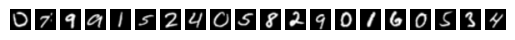

In [11]:
N = 20  # number of predictions to observe, suggest single line of plots
# Report first N predictions from all classifiers as a csv
print("K = 5, Gray scale feature: ", knn_gray_scale_5_pred[:N])
print("K = 5, HOG feature: ", knn_hog_5_pred[:N])
print("K = 1, Gray scale feature: ", knn_gray_scale_1_pred[:N])
print("K = 1, HOG feature: ", knn_hog_1_pred[:N])
print("Actual labels: ", [grid.label for grid in test][:N])

plt.figure()
for i in range(N):
    plt.subplot(1, N, i + 1)
    plt.imshow(test[i].digit, cmap='gray')
    plt.axis('off')
plt.show()


> Accuracy

In [12]:
# Report the accuracy of all classifiers

from sklearn.metrics import accuracy_score

# K = 5, Gray scale feature
knn_gray_scale_5_accuracy = accuracy_score(
    [grid.label for grid in test], knn_gray_scale_5_pred)
# K = 5, HOG feature
knn_hog_5_accuracy = accuracy_score(
    [grid.label for grid in test], knn_hog_5_pred)
# K = 1, Gray scale feature
knn_gray_scale_1_accuracy = accuracy_score(
    [grid.label for grid in test], knn_gray_scale_1_pred)
# K = 1, HOG feature
knn_hog_1_accuracy = accuracy_score(
    [grid.label for grid in test], knn_hog_1_pred)

# print as percentage with 4 decimal places
print("K\tGray\t\tHOG")
print("{}\t{:.2f} %\t\t{:.2f} %".format(
    5, knn_gray_scale_5_accuracy * 100, knn_hog_5_accuracy * 100))
print("{}\t{:.2f} %\t\t{:.2f} %".format(
    1, knn_gray_scale_1_accuracy * 100, knn_hog_1_accuracy * 100))


K	Gray		HOG
5	95.10 %		97.00 %
1	94.70 %		97.10 %


### `b.` Use KNN K = 1 with HOG features to report:

> 5 pts.
> 1.0 hrs. 


`i.`  Result for 2 test images per digit *0..9* cut out from `digits.png` itself but not aligned at the original 20 x 20 image, so you may have smaller or bigger sizes. You will have to rescale each test image to 24 x 24 because HOG must be recalculated after scaling.


In [13]:
def internal_plot(data, size_conf: tuple = (20, 1)):

    lenght = len(data)
    plt.figure(figsize=size_conf)
    for i in range(lenght):
        plt.subplot(1, lenght, i + 1)
        plt.imshow(data[i].digit, cmap='gray')
        plt.title(data[i].label)
    plt.show()

In [14]:
def internal_resize(
        data,
        winStride: tuple = (8, 8),
        padding: tuple = (8, 8),
        locations: tuple = ((0, 0),),
        size_conf: tuple = (20, 1)
):
    print("Rescaling to (24, 24)...")

    for grid in data:
        grid.digit = cv2.resize(
            grid.digit, (EXPECTED_DIMENSION, EXPECTED_DIMENSION))
        hog_feature = hog.compute(grid.digit, winStride, padding, locations)
        grid.set_hog_feature(hog_feature)

    internal_plot(data, size_conf)

    return data


In [15]:
CLASSIFIER = knn_hog_1

def predict_hog_1(data, classifier=CLASSIFIER):

    pred = classifier.predict([grid.hog_feature.flatten() for grid in data])

    # Print comparison of predicted and actual
    print("[Actual:Predicted]")
    for i in range(len(data)):
        print("[{}:{}]".format(data[i].label, pred[i]), end=" ")

    # Report the accuracy of the classifier
    accuracy = accuracy_score([grid.label for grid in data], pred)

    # print as percentage with 4 decimal places
    print("\nAccuracy = {:.2f} %".format(accuracy * 100))

In [16]:
import os


def read_file(path, check_length, size_conf: tuple = (20, 1)):

    data = []

    for filename in os.listdir(path):
        if filename.endswith(".png"):
            data.append(Grid(cv2.imread(path + filename, 0), filename[0]))
            continue
        else:
            continue

    if check_length is None and len(data) == check_length:
        print("Successfully read {} images".format(check_length))

    internal_plot(data, size_conf)

    data = internal_resize(data, size_conf)

    return data


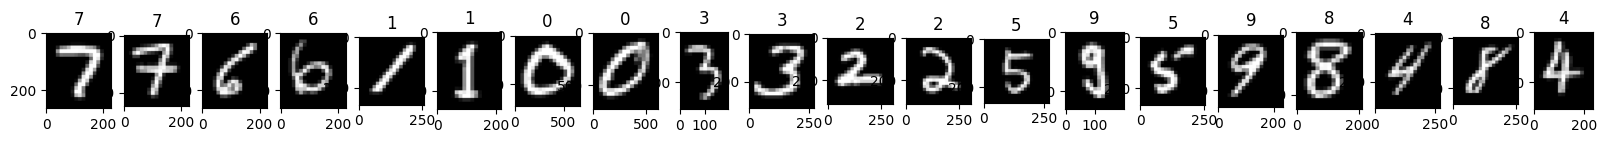

Rescaling to (24, 24)...


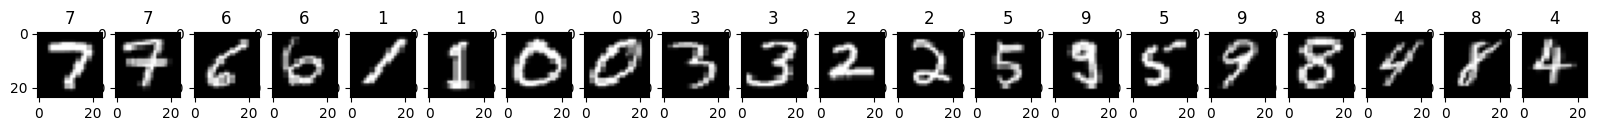

[Actual:Predicted]
[7:7] [7:7] [6:6] [6:6] [1:1] [1:1] [0:0] [0:0] [3:3] [3:3] [2:2] [2:2] [5:5] [9:9] [5:5] [9:9] [8:8] [4:4] [8:8] [4:4] 
Accuracy = 100.00 %


In [17]:
random = read_file('./random/', check_length=20)
predict_hog_1(random)


> 5 pts.
> 1.0 hrs. 


`ii.`  Result for 2 test images per digit `0..9` **you create in a Paint program** to see if you can find your character. 

- Each test image should be big to start with such as 50x50, but you should rescale it to 24 x 24 before testing.


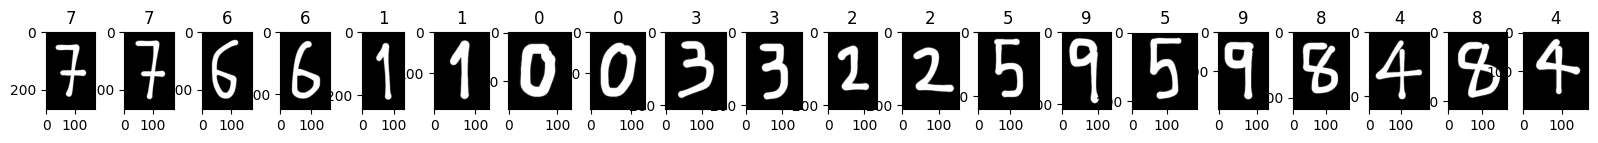

Rescaling to (24, 24)...


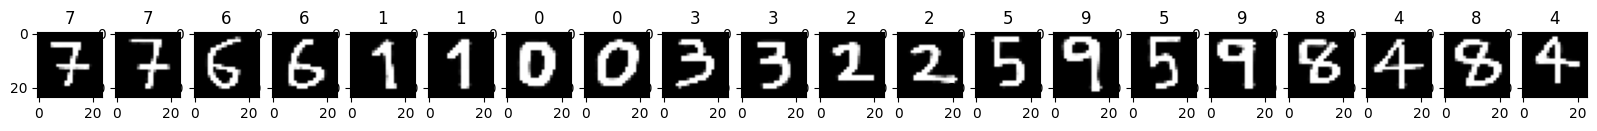

[Actual:Predicted]
[7:7] [7:4] [6:5] [6:6] [1:7] [1:7] [0:0] [0:0] [3:3] [3:3] [2:2] [2:2] [5:5] [9:4] [5:5] [9:7] [8:4] [4:4] [8:8] [4:4] 
Accuracy = 65.00 %


In [18]:
handwritten = read_file('./handwritten/', check_length=20)
predict_hog_1(handwritten)

> 5 pts.
> 1.0 hrs. 


`iii.`  Result for 4 test images of **digit 5 you create** in Paint with **white background**.

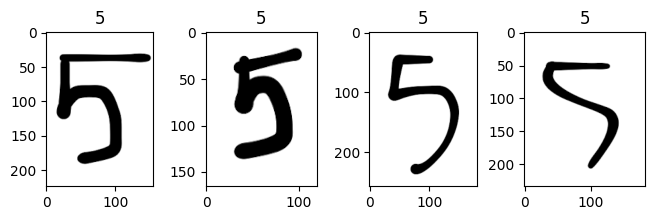

Rescaling to (24, 24)...


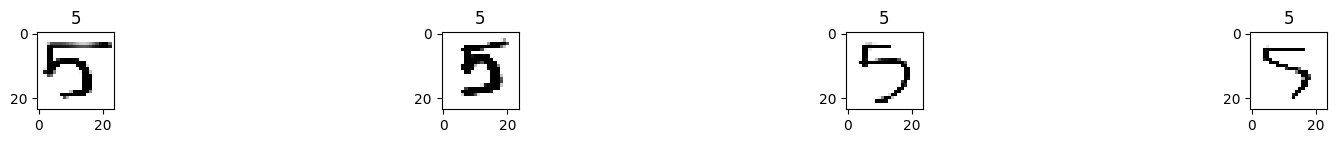

[Actual:Predicted]
[5:5] [5:5] [5:5] [5:7] 
Accuracy = 75.00 %


In [19]:
five = read_file('./five/', check_length=4, size_conf=(8, 2))
predict_hog_1(five)

> 20 pts.
> 3 hrs.

### `c.`

For each 0..9 digit in your dataset of 100 characters, 

This will be your new dataset (training and testing, combined). Report the accuracy percent for `KNN K = 1 using HOG features`. 
Is the result here better than in problem ***2a*** for KNN = 1 using HOG features?

height: 1000, width: 400


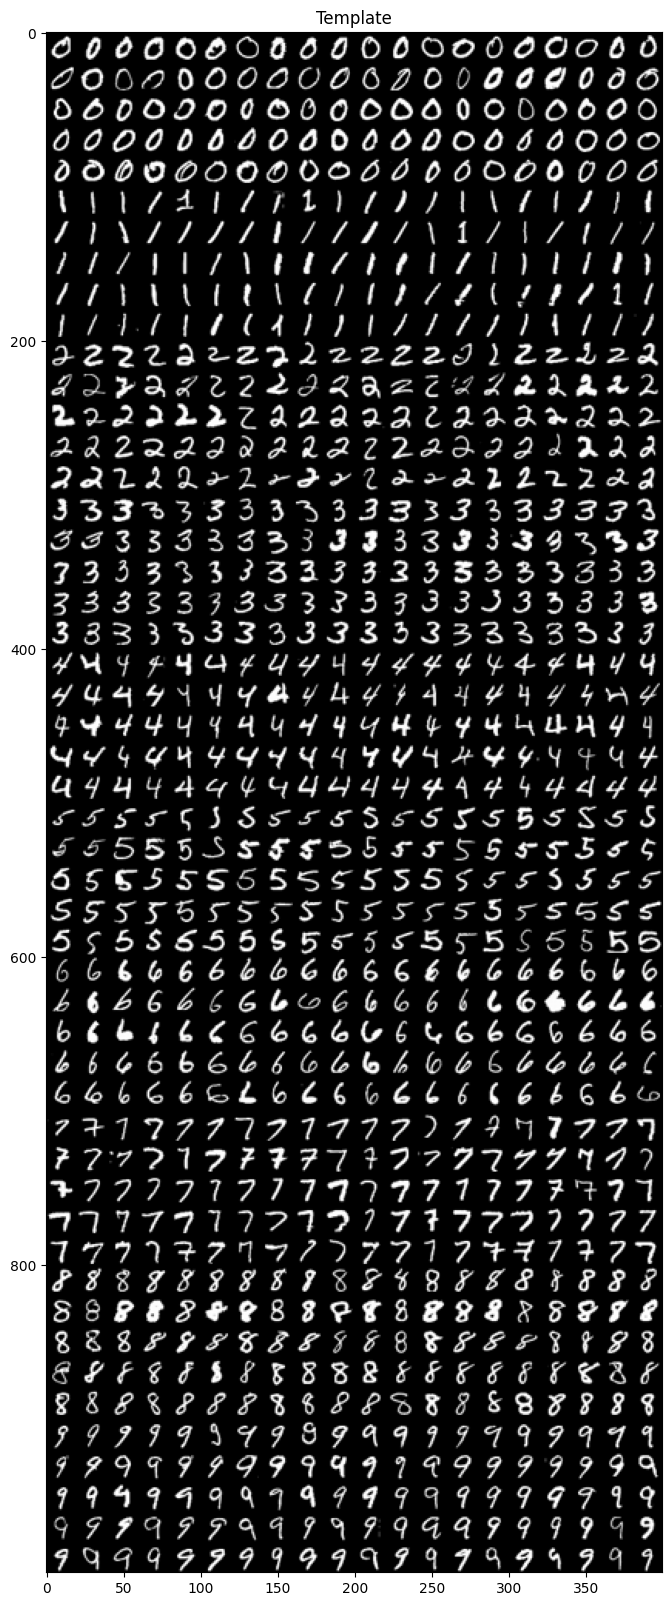

In [20]:
digits_100 = Template('digits-100.png')
digits_100.plot_template()
digits_100.cut(excepted_dimension=EXPECTED_DIMENSION)

- use `OpenCV’s auto threshold and then connected components` to find the bounding box. 
- Use that bounding box to cut out each gray-scale image and resize each back to 24 x 24.

In [21]:
CONNECTIVITY = 8

for grid in digits_100.grids:

    # Convert to grayscale
    gray_image = cv2.cvtColor(grid.get_digit(), cv2.COLOR_BGR2GRAY)
    # Apply thresholding
    threshold_value, threshold_image = cv2.threshold(
        gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Connected component analysis
    num_labels, labels_matrix, stats_matrix, centroids_matrix = cv2.connectedComponentsWithStats(
        threshold_image, connectivity=CONNECTIVITY)
    # Find the largest connected component
    # index 0 Represents the background, some sense of it B/W
    x, y, w, h, area = stats_matrix[0]
    cropped = gray_image[y:y + h, x:x + w]
    digit_new = cv2.resize(cropped, (EXPECTED_DIMENSION, EXPECTED_DIMENSION))
    grid.set_digit(digit_new)
    grid.set_hog_feature(hog.compute(
        grid.digit,
        winStride,
        padding,
        locations
    ))


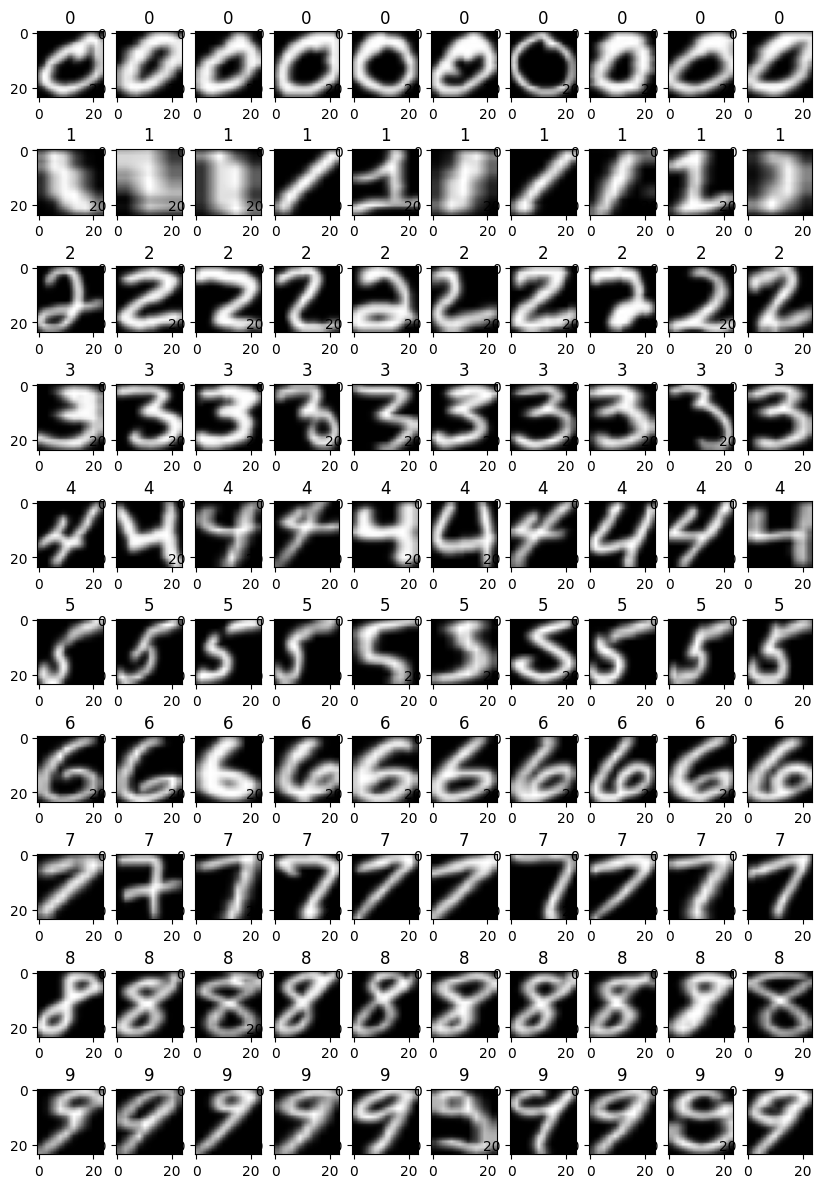

In [22]:
plt.figure(figsize=(10, 15))
# plot 10 images of each digit 10 x 10
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(digits_100.grids[i * 100 + j].digit, cmap='gray')
        plt.title(digits_100.grids[i * 100 + j].label)
plt.show()


In [23]:
# Split train (80%), test
train_c, test_c= train_test_split(digits_100.grids, test_size=0.2, random_state=0)

In [24]:
# Classify using KNN
K = 1

knn_c = KNeighborsClassifier(n_neighbors=K)
knn_c.fit(
    [grid.hog_feature.flatten() for grid in train_c],
    [grid.label for grid in train_c]
)

# Predict
knn_c_pred = knn_c.predict([grid.hog_feature.flatten() for grid in test_c])

# Print comparison of predicted and actual
print("[Actual:Predicted]")
for i in range(len(test_c)):
    print("[{}:{}]".format(test_c[i].label, knn_c_pred[i]), end=" ")

# Report the accuracy of the classifier
knn_c_accuracy = accuracy_score([grid.label for grid in test_c], knn_c_pred)

# print as percentage with 4 decimal places
print("\nAccuracy = {:.2f} %".format(knn_c_accuracy * 100))


[Actual:Predicted]
[9:7] [8:8] [2:2] [5:5] [6:6] [9:9] [0:0] [2:2] [3:3] [7:7] [4:4] [5:5] [7:7] [2:2] [5:5] [0:0] [9:9] [1:4] [0:0] [0:0] [0:0] [4:4] [3:3] [3:3] [8:8] [7:7] [0:0] [1:1] [7:9] [0:0] [8:8] [7:7] [6:6] [7:7] [4:4] [7:7] [9:9] [3:3] [9:9] [2:2] [2:2] [9:9] [6:6] [6:6] [2:2] [7:7] [8:8] [1:1] [3:3] [5:6] [3:3] [2:2] [2:2] [4:4] [8:8] [5:5] [2:2] [2:2] [9:9] [3:3] [5:5] [6:6] [1:1] [2:7] [4:4] [1:1] [2:2] [5:5] [2:2] [5:5] [7:9] [2:2] [7:7] [2:2] [9:9] [4:4] [3:3] [7:7] [6:6] [6:6] [2:2] [4:1] [3:3] [9:9] [9:9] [6:6] [2:2] [5:5] [4:4] [8:8] [4:4] [4:4] [9:9] [2:2] [6:6] [4:4] [5:5] [1:2] [3:3] [6:6] [7:7] [8:5] [0:0] [9:9] [3:3] [6:6] [6:6] [7:7] [9:9] [2:1] [0:0] [5:5] [4:4] [5:5] [2:2] [3:3] [5:5] [3:3] [4:4] [5:5] [7:7] [9:9] [1:1] [9:9] [0:0] [8:8] [3:3] [2:2] [9:9] [6:6] [4:4] [6:6] [5:5] [7:7] [7:7] [6:6] [3:3] [0:0] [5:3] [8:8] [1:1] [6:6] [5:5] [2:2] [2:2] [4:9] [3:8] [3:3] [0:0] [0:0] [2:2] [0:0] [4:7] [7:7] [9:9] [9:9] [4:4] [3:3] [8:8] [4:4] [5:5] [9:9] [6:6] [8:

In [25]:
# Compare knn_hog_1 and knn_c
print("KNN with HOG features (k=1)")
print("Without bounding box: {:.2f} %".format(knn_hog_1_accuracy * 100))
print("With bounding box: {:.2f} %".format(knn_c_accuracy * 100))

KNN with HOG features (k=1)
Without bounding box: 97.10 %
With bounding box: 90.50 %
